# ***Final Project***
---

In this project, you will develop a convolutional neural network (CNN) to perform classification, and test it out on the CIFAR-10 dataset.


The given code is a simple implement for the CIFAR-10 classification. 

The goal of the final project is to check whether you understand important concepts for training CNN such as:

*   Network architecture
*   Optimization
*   Loss function
*   Data preprocessing
*   Regularization
*   ...

Therefore, you can **modify the given code to improve the performance** of the network **except for the dataset (i.e. trainset and testset)**.

You should **upload your code and your report** including an explaination of your code and what you have changed or added.

In [7]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries.

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [8]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Data Loader**

You can load the CIFAR-10 dataset using the library `torchvision.datasets`

The details of CIFAR-10 dataset can be found in https://www.cs.toronto.edu/~kriz/cifar.html

`transforms_cifar10` is used to assemble several transforms for data preprossing.

In [9]:
transforms_cifar10 = transforms.Compose([transforms.Resize((32, 32)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])
# Data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Train dataset (with data augmentation)
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)

# Test dataset (without data augmentation)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar10)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)

# Classes of CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


 bird   cat plane  deer  deer  deer   dog  ship   cat plane   cat  deer plane  ship plane   car  ship  frog   cat  deer  bird plane truck  deer plane   cat plane  deer truck horse   cat   dog   cat  frog   cat   cat  deer  frog  deer  ship truck  deer  bird   dog truck  frog   dog horse  bird   car   dog truck   car plane   car  deer  bird truck  frog  bird horse  bird  deer  bird truck  deer  frog truck  bird plane   dog truck truck   car truck   car   dog  deer  frog  deer  deer plane horse  ship   dog truck  ship plane horse  frog  bird  bird   cat  bird  bird truck   cat   cat truck plane plane   cat plane  frog  ship truck truck   car  ship truck   dog  ship   car  bird  ship  deer   car horse   dog  deer   car   cat horse horse truck  deer  bird   dog   dog   car  bird  bird plane  deer  deer   car  bird truck  frog   car  bird plane   car  bird   dog   cat   car  frog  deer   dog   dog truck   car  frog truck  frog horse  bird  bird  bird  frog plane  frog   dog truck  ship truc

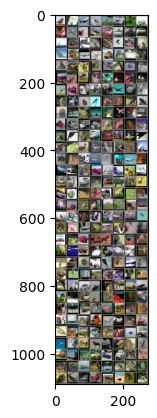

In [10]:
# Examples of dataset

def imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%5s' % classes[labels[j]] for j in range(256)))

# **Your own CNN**

You can implement your own network using libraries such as `torch.nn`and `torch.nn.functional`.

`SimpleNet` and `VGG11` are examples to help your understand the implementation of the network.

So, you can modify the given codes or create another awesome neural network for CIFAR-10 classification.

In [11]:
# VGG19

cfg = {'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']}

class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        self.features = self.make_layers(cfg['VGG19'])
        self.classifier = nn.Linear(512, 10)
        self.initialize_weights()

    def make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                in_channels = x
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

net = VGG19().to(device)


# **Loss function and optimizer**

Set the **loss function and optimizer** for training CNN.
You can modify the loss function or optimizer for better performance.

In [12]:
# Loss function and optimizer
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9,0.999))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# **Train the network**

Train your own network using the above loss function and optimizer.

In [13]:
# Train the model
epochs = 100  # number of epochs


for epoch in range(epochs):

    loss_tmp = 0.0
    epoch_loss = 0.0 
    
    for i, data in enumerate(trainloader, start=0):
        # Load the data
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Estimate the output using the network
        outputs = net(inputs)

        # Calculate the loss between the output of the network and label
        loss = loss_fun(outputs, labels)

        # Optimize the network 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_tmp += loss.data
        epoch_loss += loss.data

        if i % 5000 == 4999:    # Print loss every 5000 mini-batches
            print('[Epoch - %d, Iteration - %5d] Loss: %.3f' %
                  (epoch + 1, i + 1, loss_tmp / (i+1)))
            loss_tmp = 0.0

    # Update the learning rate according to the learnig rate scheduler
    scheduler.step(epoch_loss / (i+1))

    # Print the epoch loss
    print('[Epoch - %d] Loss: %.3f' %(epoch + 1, epoch_loss / (i+1)))

print('Finished Training')

[Epoch - 1] Loss: 1.626
[Epoch - 2] Loss: 1.098
[Epoch - 3] Loss: 0.879
[Epoch - 4] Loss: 0.748
[Epoch - 5] Loss: 0.659
[Epoch - 6] Loss: 0.589
[Epoch - 7] Loss: 0.538
[Epoch - 8] Loss: 0.490
[Epoch - 9] Loss: 0.454
[Epoch - 10] Loss: 0.428
[Epoch - 11] Loss: 0.398
[Epoch - 12] Loss: 0.363
[Epoch - 13] Loss: 0.339
[Epoch - 14] Loss: 0.324
[Epoch - 15] Loss: 0.309
[Epoch - 16] Loss: 0.289
[Epoch - 17] Loss: 0.270
[Epoch - 18] Loss: 0.259
[Epoch - 19] Loss: 0.237
[Epoch - 20] Loss: 0.229
[Epoch - 21] Loss: 0.217
[Epoch - 22] Loss: 0.202
[Epoch - 23] Loss: 0.201
[Epoch - 24] Loss: 0.186
[Epoch - 25] Loss: 0.178
[Epoch - 26] Loss: 0.167
[Epoch - 27] Loss: 0.162
[Epoch - 28] Loss: 0.155
[Epoch - 29] Loss: 0.139
[Epoch - 30] Loss: 0.140
[Epoch - 31] Loss: 0.134
[Epoch - 32] Loss: 0.127
[Epoch - 33] Loss: 0.123
[Epoch - 34] Loss: 0.114
[Epoch - 35] Loss: 0.111
[Epoch - 36] Loss: 0.105
[Epoch - 37] Loss: 0.103
[Epoch - 38] Loss: 0.098
[Epoch - 39] Loss: 0.093
[Epoch - 40] Loss: 0.091
[Epoch - 

# **Test the network**

Test the trained network using the testset.

Accuracy of the network on the 10,000 test images is the final accuracy of your network. 

The closer the accuray is to 100%, the better the network classifies the input image.

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog truck  bird  deer   car truck   dog  deer  frog   dog  frog plane truck   cat truck horse  frog truck  ship plane   cat  ship  ship horse horse  deer  frog horse   cat  frog   cat  frog  bird   car  bird   cat horse  bird  frog  ship  ship plane  bird truck   cat   cat  ship  ship   car   car horse  bird   dog  bird horse  ship truck plane   cat  ship  frog  deer  frog  frog plane plane horse  deer   dog  frog   cat   car   car   cat  frog  ship horse  deer plane  frog  bird   car   cat plane  deer  bird horse  ship   cat   car  bird  ship plane  ship   cat   dog  bird  deer   car  ship truck   car  bird truck horse  bird truck  frog   dog  frog   cat  ship horse  frog  bird   dog  bird  ship truck  frog plane plane   dog  bird truck   dog  deer  bird   car  frog  frog  s

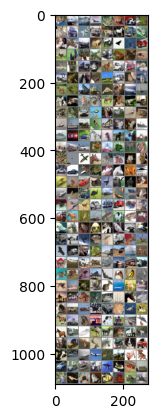

In [14]:
# Test the trained model with sample

dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(256)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = net(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(256)))

In [15]:
# Test the trained model with overall test dataset

correct = 0
total = 0

with torch.no_grad():  # Disable gradient tracking
  net.eval()
  for data in testloader:
    # Load the data
    inputs_test, labels_test = data
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    # Estimate the output using the trained network
    outputs_test = net(inputs_test)
    _, predicted = torch.max(outputs_test.data, 1)
    
    # Calculate the accuracy
    total += labels_test.size(0)
    correct += (predicted == labels_test).sum()


# Final accuracy
print('Accuracy of the network on the 10,000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10,000 test images: 92 %
